# 収益管理モジュール rm と収益管理システム MERMO 

> 動的価格付け理論に基づく収益管理システム MERMO (MEta Revenue Management Optimzer) 


In [ ]:
#| default_exp rm

In [ ]:
#| include: false
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#| export
import matplotlib.pyplot as plt
#from gurobipy import Model, quicksum, GRB
from mypulp import Model, quicksum, GRB
from scipy.stats import poisson, expon

import copy
import pickle
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import plotly
import pandas as pd
import random
import string
import datetime
import math
from collections import OrderedDict, defaultdict
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from scipy.stats import norm
import networkx as nx
from IPython.display import Image, YouTubeVideo
import sys
sys.path.append('..')

folder = "./data/rm/"

#hide
## Streamlitで作成した簡易システムの紹介ビデオ

収益管理システム MERMO (MEta Revenue Management Optimzer)

## はじめに


一般には，企業体の資産の多くは陳腐化し，会計上は減価償却されるものである．
しかし，収益管理における陳腐化資産とは，会計上の資産としては長期にわたって価値をもつものであるが，短期的な意味でその価値がなくなるものを指す．
その代表例として航空機の座席がある．つまり，航空機の座席自体は，航空機会社の資産としてその価値は徐々に減価償却されるものであるが，ある特定の時期の，特定の便の，特定の座席（たとえばファーストクラスの窓際の席）は，
乗客を確保できなければ収益を生むことができないので，その価値を失うと考えるのである．

航空機の座席以外にも，列車や船の座席（寝台），ホテルや旅館の部屋，
レンタカー，ゴルフ場におけるプレーの権利，相撲や野球の観戦券，テレビのコマーシャルの時間帯，
コインパーキングの駐車場なども陳腐化資産である．
見方によっては，生鮮食料品なども期限がくると急速にその価値を失うので陳腐化資産と考えられるが，
ほとんどの研究は，航空機や電車の座席，ホテルや旅館などの宿泊施設の部屋，レンタカーに代表されるレンタル商品など，
長期的な観点における資産の所得の可否は固定されているものの，
特定の時期におけるその利用が商品として販売されているものを対象としている．

これらの陳腐化資産に対して，適当な時期における適当な価格付けや資産の在庫への需要の割り当てを行い，
顧客の需要を適切に管理（および創生）することによって，企業体の収益を向上させることができる．
これが収益管理（revenue management）よばれる理論および実務の体系である．
従来は，「報酬管理」の用語が多く用いられていたが，最近は報酬（費用を考慮しない収入）だけを目的とするのではなく，収入から費用を減じたものを最大化することを目的とすることを強調するために，
「収益管理」という用語が用いられるようになった．ここでも，それにならい収益管理とよぶことにする．

## 動的価格最適化（ダイナミックプライシング）

価格 $p$ を離散値から選択し，収益の最大化を行う． すなわち，行動は価格であり，その集合を $A$， 行動の数を $K=|A|$ とする．

需要 $d$ は価格の関数であり，以下の線形関数と仮定する．

$$d = \beta_0 + \beta_1 p + \epsilon$$

ただし，パラメータ $\beta$ は未知であり，学習しながら最適化を行うものとする．

そのために，強化学習（文脈バンデット）を用いる．

行動は価格 $p$ であり， それを与えると環境は需要量を返す． 報酬関数は $p d$ であり，すべての期間 $1,2,\ldots,T$ における報酬の合計を最大化する．

$1$ から $T$ までの期を，エポックと呼ばれる部分区間に分割する． $m$ 番目エポックの終了期を $\tau_m = 2^m  (m=1,2,\cdots)$  と設定する．

エポックは期間 $[\tau_{m-1}+1, \tau_m]$ （ただし $\tau_0=0$と仮定）となる．

まず， エポック $m (\geq 1)$ では，$t \in [1, \tau_{m-1}]$ の価格と需要の組 $(p_t,d_t)$ をもとに，
最小二乗法で需要・価格関数のパラメータ  $\hat{\beta}$ の推定を行う．

次に， $t =\tau_{m-1}+1, \ldots, \tau_m$ に対して，以下を実行する．

パラメータ  $\hat{\beta}$ に対して最も利益が高くなる価格 $\hat{p}$ を計算する．
最大報酬 $\hat{f} = \hat{p} (\hat{\beta}_0 + \hat{\beta}_1 \hat{p})$ との差に応じて，ランダムに他の価格も選択する．
（エポック $1$ では価格と需要のデータがないので，ランダムに価格を選び $\hat{p}$ とする．）

具体的には，確率的保証を与えるためのパラメータ $\delta$ に対して，以下のようにステップサイズを決める（ただし $\tau_1=1$）．

$$
\gamma_m = (1/30) \sqrt{(K \tau_{m-1})/\log(\tau_{m-1}/\delta)}
$$

行動 $a$ に対する報酬関数の推定値 $\hat{f}(a)$ に対して，以下に定義される確率 $P$ によって行動を決める． 
$$
 a^* = \arg\max \hat{f}(a)
$$

$$
P(a) = \left\{ \begin{array}{ll}  
         1/(K+\gamma_m (\hat{f}(a^*)- \hat{f}(a)) & a \neq a^* \\
         1- \sum_{a \neq a^*} P(a)                & a = a^*  
         \end{array} \right.
$$


選択された価格に対して環境から需要が返される．価格と需要の組 $(p_t,d_t)$ を保管する．


需要量の合計（在庫量）に制限がある場合は，動的計画もしくは強化学習で最適な行動（価格）を求めてから，
1期の報酬でなく，最終期までの期待利得を用いて価格をランダムに選択する．

この際，予測の誤差も加味して強化学習を適用する方法も考えられる． 
これは新しいアプローチであり，実験的解析で有効性を確認する必要がある．


In [ ]:
#| include: false
from sklearn.metrics import mean_squared_error
np.random.seed(seed=32)

beta0, beta1 = 50., -1. #需要関数は beta0+beta1*price+N(0,sigma^2) と仮定
sigma = 1.

actions = np.array(np.linspace(15,35,5)) #価格の候補（行動）
def random_demand(actions,sigma=1.):
    epsilon = np.random.normal(0.,sigma)
    return beta0+beta1*actions + epsilon

M = 10 #エポック数
K = len(actions) #行動の数
delta = 0.1 #確率的保証のための定数（この確率以上でリグレットが保証される）
Scaling = 1. #1/Scalingで報酬をスケーリング

tau = [0] #エポックの終了期
for m in range(1,M):
    tau.append(2**m)
T = 2**(M-1)+1 #計画期間
demand = np.zeros(T)
price = np.zeros(T)
reward_hist = np.zeros(T)
for m in range(1,M):
    #forecast
    gamma = np.sqrt(K*tau[m-1]/np.log((tau[m-1]+0.001)/delta))/Scaling #学習率
    #print("step-size=",gamma)
    if m==1: #最初のエポックなので，価格と需要を生成
        p = np.random.choice(actions)
        d = random_demand(p)
        price[0] = p
        demand[0] = max(d,0.0)
    X = price[:tau[m-1]+1].reshape(-1, 1)
    y = demand[:tau[m-1]+1].reshape(-1, 1)
    reg = LinearRegression() # 線形回帰クラスのインスタンス reg 生成
    reg.fit(X, y)           # fitによる訓練
    #平均二乗誤差から誤差項の標準偏差を推定
    ypredict = reg.predict(X)  
    mse = mean_squared_error(X, ypredict)
    #print("sigma=",np.sqrt(mse))
    yhat = reg.predict(actions.reshape(-1, 1))  #各行動（価格）に対する需要量
    #action
    for t in range(tau[m-1]+1,tau[m]+1):
        reward = yhat*actions.reshape(-1, 1) #報酬（推定値） #容量を考慮する場合には，ここを reward + V(t,I-yhat) に変更
        max_reward = np.max(reward)
        max_idx = np.argmax(reward)
        prob = 1./(K+gamma*(max_reward-reward))
        prob_no_max = np.delete(prob, max_idx, axis=0)
        total_prob = np.sum(prob_no_max) #最大報酬以外の選択確率の和
        prob[max_idx] = 1.- total_prob
        p = np.random.choice(actions,p=prob.reshape(-1,))
        d = max(random_demand(p),0)
        price[t] = p
        demand[t] = d
        reward_hist[t] = p*d #合計報酬
        #print(p,d,prob)
    
print("towal reward=", reward_hist.sum())

towal reward= 319517.2567130923


In [ ]:
#| include: false
print("y-切片= ",reg.intercept_)
print("係数 = ",reg.coef_)

y-切片=  [51.9684397]
係数 =  [[-1.08121136]]


In [ ]:
#| include: false
print(actions)
random_demand(actions,sigma=0.)

[15. 20. 25. 30. 35.]


array([35., 30., 25., 20., 15.])

### 動的計画による価値関数の推定

需要関数 $d = \beta_0 + \beta_1 p$ であると仮定したとき， 期 $t$ と残り在庫（容量） $c$ のときの，それ以降の期の報酬の合計（価値関数） $V(t,c)$ 
は以下の再帰式で計算できる．

$$
V(t,c) = \max_{p} \left\{ (\beta_0 + \beta_1 p)p +V(t+1,c-(\beta_0 + \beta_1 p))  \right\}
$$

残り在庫に対する費用が $0$ であると仮定したときの初期条件は，以下のようになる．

$$V(t,0) = 0  \ \ \forall t=0,1,\ldots,T-1$$  

$$V(T,c) = 0  \ \ \forall c=0,1,\ldots,C$$ 

残り在庫 $1$ あたりに費用 $h$ を課す場合には，2番目の初期条件を以下のように変更する．

$$V(T,c) = hc  \ \ \forall c=0,1,\ldots,C$$ 

需要と容量を離散値で近似して，動的計画を適用する．

期数と容量大きい場合には，関数近似を行う必要がある． 

In [ ]:
#| include: false
#実験
C = 1000
T= 50
n_samples = 1
sigma = 0.
V = np.zeros( (T+1,C+1) )
A = np.zeros( (T+1,C+1) )
for t in range(T-1,-1,-1):
    for c in range(1,C+1):
        #推定値に誤差がある場合には，ここでサンプリングして期待値をとる
        reward_to_go = [0. for i in range(len(actions))]
        for sample in range(n_samples):
            demand = random_demand(actions.reshape(-1, 1),sigma=sigma)
            for i,a in enumerate(actions):
                reward_to_go[i] += a*min(demand[i][0],c) + V[t+1,max(c-max(int(demand[i][0]),0),0)]
                #reward = demand*actions.reshape(-1, 1)

        max_v, max_a = 0,-1
        for i,a in enumerate(actions):
            #reward_to_go = a*min(demand[i][0],c) + V[t+1,max(int(c-demand[i]),0)]
            if reward_to_go[i] > max_v:
                max_v = reward_to_go[i]
                max_a = a
        V[t,c] = max_v
        A[t,c] = max_a
        #print(t,c,V[t,c],A[t,c])

### 在庫と価格のシミュレーション

不確実性を考慮した場合には，価格は一定（固定価格方式）の方が良い結果が出ることが多い．


In [ ]:
#| include: false
sigma = 0.1
C = 800
I = C
price_list, inv_list = [],[]
reward = 0.
for t in range(T):
    a = A[t,max(I,0)]
    # 価格を徐々に上げる方法
#     if T-t<=10:
#         a = 30
#     else:
#         a = 35
    demand = random_demand(a,sigma)
    inv_list.append(I)
    price_list.append(a)
    I -= int(demand)
    print(t,I,a,demand)
    if I>=0:
        reward += a*demand
df = pd.DataFrame({"Inventory":inv_list, "Price":price_list})
fig = px.line(df,y="Price")
#plotly.offline.plot(fig);
print("total reward=",reward)

0 780 30.0 20.062196858398284
1 760 30.0 20.04783044943654
2 741 30.0 19.969530196922534
3 721 30.0 20.088624025936124
4 701 30.0 20.121667101187267
5 681 30.0 20.07049673895855
6 662 30.0 19.88619773366475
7 642 30.0 20.04397848318034
8 623 30.0 19.956668418598106
9 603 30.0 20.201729164752507
10 588 35.0 15.123103143373104
11 574 35.0 14.937920248473421
12 560 35.0 14.976820458297665
13 541 30.0 19.8726010347924
14 526 35.0 15.19583521258575
15 511 35.0 15.053981741785545
16 497 35.0 14.892736809903889
17 483 35.0 14.914464644294277
18 469 35.0 14.974546976821228
19 455 35.0 14.982453263867283
20 436 30.0 19.935591306423657
21 421 35.0 15.042401167067913
22 406 35.0 15.082370994892862
23 391 35.0 15.081419884027484
24 376 35.0 15.139445561390222
25 361 35.0 15.073644140334103
26 346 35.0 15.090729002403512
27 331 35.0 15.109228614855287
28 317 35.0 14.877815971567058
29 302 35.0 15.046150798399914
30 287 35.0 15.113977003640217
31 272 35.0 15.057714681389829
32 257 35.0 15.0498264661

In [ ]:
import plotly.express as px
# fig = px.imshow(V.T)
# plotly.offline.plot(fig);

In [ ]:
# fig = px.imshow(A[:,:])
# plotly.offline.plot(fig);

### ネットワーク型在庫割り当てに対する数理計画モデル


座席の価値が 0 になる時刻（航空機の出発する時刻）を 0 とし，現在時刻を $T$ とする．
すなわち，時刻は $T,T-1,\cdots,t+1,t,t-1,\cdots,0$ と未来になるにつれ小さくなるように添え字をつけるものとする
（カウントダウンと思えば良い）．



ホテルやレンタカーなどへの応用の場合には，無限期間を考える必要があるが，
無限期間の問題を有限期間の問題に帰着させるための常套手段である
ローリング・ホライズン方式（rolling horizon method）を用いるものと仮定する．
ここで，ローリング・ホライズン方式とは，現在時刻 $T$ から最終時刻 $0$ までの問題を解くことによって，
現時点での意思決定を行い，次の期（$T-1$期）の意思決定の際には，時刻を $1$ 進めて，
$T-1$期から $-1$ 期までの問題を解き，という具合に無限期間を有限期間で近似する方式である


行程（資源）の数を $\ell$，　旅程（需要、サービス）の数を $m$ とする．
行程 $i$ の残り数を行程の容量とよび，　現時点（時刻 $T$）における行程 $i$ の容量を $N_i$ と記す．
旅程 $j$ は，旅程に含まれる行程の集合と運賃クラスによって特徴づけられる．
旅程 $j$ の運賃（収益）を $R_j$，行程が旅程に含まれることを表す行列を $A=[a_{ij}]$ とする．
ここで $a_{ij}$ は，旅程 $j$ が行程 $i$ を含むとき $1$，それ以外のとき $0$ を表す．
より一般的には，$a_{ij}$ は $0$ 以上の整数をとる場合もある．
たとえば，$10$人単位の団体客の場合には団体割引価格を適用する場合には，$a_{ij}=10$ となる．


時刻 $t$ から時刻 $0$ の間の旅程（需要、サービス）$j$ の総和を表す確率変数を $D^t_j$，その期待値を $E[D^t_j]$ と記す．
旅程 $j$ を受け入れる総数を表す変数 $y_j$ を導入する．
実際には座席数は整数であるが，座席数はある程度大きい整数と考え，実数に緩和して適当な丸め操作で整数に変換する方法を用いるものとする．

旅程に行程（資源）の容量 $n_i (i=1,\cdots,\ell)$ を割り振る線形計画問題は，以下のようになる．
$$
 \begin{array}{l r l l } 
   LP(n,E[D^t]) &= maximize &  \sum_{j=1}^m R_j y_j             &                         \\
              &    s.t.   &  \sum_{j=1}^m a_{ij} y_j \leq n_i & \forall i=1,\cdots,\ell \\
              &                &  0 \leq y_j \leq E[D^t_j]           & \forall j=1,\cdots,m 
 \end{array}
$$

上式で最初の制約は，資源の容量制約であり，2番目の制約は需要量の上限制約である．

確率変数 $D^t$ を離散化して近似する方法も実務的には有効である．
いま，$t$ 期以降に旅程 $j$ が発生する量を表す確率変数 $D_j^t$ が互いに独立であり，
$K$ 個の離散的な値 $\Delta_{j1}< \Delta_{j2}< \cdots <\Delta_{j K}$ をとるものとする． 
また，旅程 $j$ の受け入れ総数を表す変数 $y_j$ は，$K$個の変数 $z_{jk} (k=1,\cdots,K)$ に分解して扱う．
以下の確率的線形計画問題は，変数  $z_{jk}$ を確率変数の実現値を知る前に決定するので，即時決定（here and now）アプローチとよばれる．

$$
 \begin{array}{l r l l } 
   SLP(n,D^t) &= maximize &  \sum_{j=1}^m  \sum_{k=1}^K R_j \Pr \{D_j^t \geq \Delta_{jk} \} z_{jk} &      \\
              &  s.t.  &  \sum_{j=1}^m  a_{ij} \sum_{k=1}^K z_{jk} \leq n_i & \forall i=1,\cdots,\ell  \\
              &                &  0 \leq z_{j 1}  \leq \Delta_{j1}                & \forall j=1,\cdots,m             \\
              &                &  0 \leq z_{j k}  \leq \Delta_{jk}-\Delta_{j,k-1} & \forall j=1,\cdots,m, k=2,\cdots,K 
 \end{array}
$$


この問題は，単純リコース（simple recourse）をもつ確率計画問題と解釈できる．
変数  $z_{jk}$ を確率変数の実現値を知る前に決定し，この時点では収益 $R_j z_{jk}$ を得るものとする．
確率変数 $D_j^t$ の実現値が $\Delta_{jk}$ 未満の場合には， 
実際には需要がなかったので $z_{jk}=0$ となり， リコース費用（recourse cost）$R_j z_{jk}$ を支払うものとする．
確率変数 $D_j^t$ の実現値が $\Delta_{jk}$ 未満になる確率は，$\Pr \{D_j^t < \Delta_{jk} \}$ であるので，
目的関数は， 
$$
 \sum_{j=1}^m  \sum_{k=1}^K R_jz_{jk}  - \sum_{j=1}^m  \sum_{k=1}^K R_j \Pr \{D_j^t < \Delta_{jk} \} z_{jk} 
=\sum_{j=1}^m  \sum_{k=1}^K R_j \Pr \{D_j^t \geq \Delta_{jk} \} z_{jk}
$$
となる．

需要の期待値 $E[D^t]$ を用いるかわりに，確率変数 $D^t$ をサンプリングすることによって近似の精度を上げる方法が提案されている．
確率変数 $D^t$ を入力とした以下の線形計画問題を解く．
$$
 \begin{array}{l r l l } 
   LP'(n,D^t)  &= maximize &  \sum_{j=1}^m R_j y_j             &                         \\
              &  s.t.      &  \sum_{j=1}^m a_{ij} y_j \leq n_i & \forall i=1,\cdots,\ell \\
              &                &  0 \leq y_j \leq D^t_j            & \forall j=1,\cdots,m 
 \end{array}
$$

$D^t_j$ のサンプルを適当な個数発生させ，各々のサンプルに対して線形計画問題を解くことによって $LP'(n,D^t)$ の期待値を得る．
このアプローチは，確率変数の実現値を知った後で最適化を行うので， 待機決定（wait and see）の確率計画モデルと考えられる．


### 入札価格コントロール方策

ここでは，線形計画問題を解くことによって得られる双対変数の情報を用いた在庫コントロール方策について考える．
線形計画問題における容量制約に対する最適双対変数を $v_i (i=1,\cdots,\ell)$ とする．
在庫割り当てモデルにおいては，$v_i$ は行程に対する入札価格（bid price）とよび， 旅程に含まれる行程の入札価格の和で機会費用 $OC_j(n,t)$ を近似する．

旅程 $j$ に含まれる行程の入札価格の和が，旅程の収益以下であれば，その旅程は受け入れられ，それ以外の場合は拒否される．
すなわち，入札価格 $v$ を用いた近似方策は，旅程 $j$ が発生したときに，
$$
\begin{array}{l c l } 
  R_j \geq \sum_{i: a_{ij}=1} v_i  & \Rightarrow & 受け入れ \\
  それ以外                  & \Rightarrow & 拒否
\end{array}
$$
とする方策である。このような予約のさばき方を入札価格コントロール方策（bid-price control policy）とよぶ．

### 等価確定コントロール方策

上で述べた入札価格コントロール方策は，複数の最適双対変数が存在する可能性が高いことや，
（旅程が複数の行程を含んでいる場合には基底が変化するので）双対変数の和が近似として不適当となる可能性がある．
この弱点を克服するために，以下のように旅程 $j$ を受け入れた場合とそうでない場合の $2$通りの線形計画問題を解くことによって
旅程 $j$ の機会費用 $OC_j(n,t)$ を近似する方策が提案されている．
$$
  LP(n,E(D^{t-1}))-LP(n-A^j,E(D^{t-1}))
$$

線形計画問題のかわりに確率的線形（整数）計画問題の最適値（もしくは近似値）を用いる方法も考えられる． これらの近似を用いた方策を総称して等価確定コントロール方策（certainty equivalent control policy）とよぶ．

より正確には，行程容量を表すベクトル $n$ と$t$期以降の需要量を表す確率変数 $D^t$ に対する数理計画モデルの最適値（もしくは近似値）を $MP(n,D^t)$ と記すとき，
等価確定コントロール方策とは，旅程 $j$ が発生したときに，
$$
\begin{array}{l c l } 
  R_j \geq MP(n,D^{t-1})-MP(n-A^j,D^{t-1})    & \Rightarrow & 受け入れ \\
  それ以外                             & \Rightarrow & 拒否
\end{array}
$$

### サンプルデータ生成関数 make_sample_data_for_rm

In [ ]:
#| export
def make_sample_data_for_rm(num_periods):
    """
    make a sample data for revenue management
    """
    ell = num_periods
    res = list(range(ell))
    j = 0
    # 3 types of demands whose duratios are 1,2,3 
    dem = {1:20., 2:6., 3:3. }
    rev = {1:1000., 2:3000., 3:5000.} 
    a, demand, revenue = {}, {}, {}
    for dur in range(1,4): #duration 
        for r in range(ell+1-dur):
            for i in range(r,r+dur):
                a[i,j] = 1
            demand[j]= dem[dur]
            revenue[j] = rev[dur]
            j+=1
    m = j # number of demands   

    capacity ={i: 10. for i in res}
    return demand, revenue, a, capacity

### make_sample_data_for_rm関数の使用例

In [ ]:
demand, revenue, a, capacity = make_sample_data_for_rm(5)
print("demand", demand)
print("revenue", revenue)
print("usage", a)
print("capacity", capacity)

demand {0: 20.0, 1: 20.0, 2: 20.0, 3: 20.0, 4: 20.0, 5: 6.0, 6: 6.0, 7: 6.0, 8: 6.0, 9: 3.0, 10: 3.0, 11: 3.0}
revenue {0: 1000.0, 1: 1000.0, 2: 1000.0, 3: 1000.0, 4: 1000.0, 5: 3000.0, 6: 3000.0, 7: 3000.0, 8: 3000.0, 9: 5000.0, 10: 5000.0, 11: 5000.0}
usage {(0, 0): 1, (1, 1): 1, (2, 2): 1, (3, 3): 1, (4, 4): 1, (0, 5): 1, (1, 5): 1, (1, 6): 1, (2, 6): 1, (2, 7): 1, (3, 7): 1, (3, 8): 1, (4, 8): 1, (0, 9): 1, (1, 9): 1, (2, 9): 1, (1, 10): 1, (2, 10): 1, (3, 10): 1, (2, 11): 1, (3, 11): 1, (4, 11): 1}
capacity {0: 10.0, 1: 10.0, 2: 10.0, 3: 10.0, 4: 10.0}


### 飲食店の例

In [ ]:
days = 7         # 1 week
dem = [3,5,4,2]  # demand 
dem_weekend = [4,7,5,3] # weekend demand 
rev = 2000
rev_weekend = 3000
average_stay = 2 # hours
start, finish = 6, 11 #start and finish time
demand, revenue, a = {}, {}, {}
demand_, revenue_, a_ = {}, {}, {}
# _ contains demand of (hour, day, start_hour)
for d in range(days):
    for t in range(start, finish+1-average_stay):
        if d<=4:
            demand_[d,t] = dem[t-start] 
            revenue_[d,t] = rev
        else: #week end 
            demand_[d,t] = dem_weekend[t-start] 
            revenue_[d,t] = rev_weekend
        for tt in range(t,t+average_stay):
            a_[tt,d,t] = 1 
# convert to demand
slots = finish-start-average_stay + 1  # number of slots per day
for (ii,d,s) in a_:
    i = d*slots+ii-start
    j = d*slots+s-start
    a[i,j] = 1
    demand[j] = demand_[d,s]
    revenue[j] = revenue_[d,s]
for i in range(slots*days+1):
    capacity[i] = 7

## 予約需要データフレームの読み込み

dataモジュールで生成した予約需要のcsvファイルを読み込む。

In [ ]:
reserve_demand_df = pd.read_csv(folder + "reserve_demand.csv",index_col=0)
reserve_demand_df.tail()

,reserve,checkin,class_name,demand
2785,2019-02-28,2019-03-01,B,15
2786,2019-02-28,2019-03-01,A,1
2787,2019-03-01,2019-03-01,C,15
2788,2019-03-01,2019-03-01,B,11
2789,2019-03-01,2019-03-01,A,2


In [ ]:
resource = list(set(reserve_demand_df.checkin)) #checkin date = resource (one resource)
resource.sort()
# checkin date and class => service => revenue and demand distribution  
demand_history = {} # dictionary that maintains demand[checkin, leadtime, class]
for row in reserve_demand_df.itertuples():
    tdelta = pd.to_datetime(row.checkin)- pd.to_datetime(row.reserve)
    demand_history[row.checkin, tdelta.days, row.class_name] = row.demand 

## 実データの読み込み

>  "Hotel booking demand datasets": https://www.sciencedirect.com/science/article/pii/S2352340918315191

２種類のデータ (H1=リゾートホテル, H2=シティホテル) 


ADR	Numeric	Average Daily Rate as defined by [5]	BO, BL and TR / Calculated by dividing the sum of all lodging transactions by the total number of staying nights
Adults	Integer	Number of adults	BO and BL
Agent	Categorical	ID of the travel agency that made the bookinga	BO and BL
ArrivalDateDayOfMonth	Integer	Day of the month of the arrival date	BO and BL
ArrivalDateMonth	Categorical	Month of arrival date with 12 categories: “January” to “December”	BO and BL
ArrivalDateWeekNumber	Integer	Week number of the arrival date	BO and BL
ArrivalDateYear	Integer	Year of arrival date	BO and BL
AssignedRoomType	Categorical	Code for the type of room assigned to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons	BO and BL
Babies	Integer	Number of babies	BO and BL
BookingChanges	Integer	Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation	BO and BL/Calculated by adding the number of unique iterations that change some of the booking attributes, namely: persons, arrival date, nights, reserved room type or meal
Children	Integer	Number of children	BO and BL/Sum of both payable and non-payable children
Company	Categorical	ID of the company/entity that made the booking or responsible for paying the booking. ID is presented instead of designation for anonymity reasons	BO and BL.
Country	Categorical	Country of origin. Categories are represented in the ISO 3155–3:2013 format [6]	BO, BL and NT




CustomerType	Categorical	Type of booking, assuming one of four categories:	BO and BL
Contract - when the booking has an allotment or other type of contract associated to it;
Group – when the booking is associated to a group;
Transient – when the booking is not part of a group or contract, and is not associated to other transient booking;
Transient-party – when the booking is transient, but is associated to at least other transient booking
DaysInWaitingList	Integer	Number of days the booking was in the waiting list before it was confirmed to the customer	BO/Calculated by subtracting the date the booking was confirmed to the customer from the date the booking entered on the PMS




DepositType	Categorical	Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:	BO and TR/Value calculated based on the payments identified for the booking in the transaction (TR) table before the booking׳s arrival or cancellation date.
No Deposit – no deposit was made;
In case no payments were found the value is “No Deposit”.
If the payment was equal or exceeded the total cost of stay, the value is set as “Non Refund”.
Non Refund – a deposit was made in the value of the total stay cost;
Otherwise the value is set as “Refundable”
Refundable – a deposit was made with a value under the total cost of stay.
DistributionChannel	Categorical	Booking distribution channel. The term “TA” means “Travel Agents” and “TO” means “Tour Operators”	BO, BL and DC
IsCanceled	Categorical	Value indicating if the booking was canceled (1) or not (0)	BO
IsRepeatedGuest	Categorical	Value indicating if the booking name was from a repeated guest (1) or not (0)	BO, BL and C/ Variable created by verifying if a profile was associated with the booking customer. If so, and if the customer profile creation date was prior to the creation date for the booking on the PMS database it was assumed the booking was from a repeated guest
LeadTime	Integer	Number of days that elapsed between the entering date of the booking into the PMS and the arrival date	BO and BL/ Subtraction of the entering date from the arrival date
MarketSegment	Categorical	Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”	BO, BL and MS




Meal	Categorical	Type of meal booked. Categories are presented in standard hospitality meal packages:	BO, BL and ML
Undefined/SC – no meal package;
BB – Bed & Breakfast;
HB – Half board (breakfast and one other meal – usually dinner);
FB – Full board (breakfast, lunch and dinner)
PreviousBookingsNotCanceled	Integer	Number of previous bookings not cancelled by the customer prior to the current booking	BO and BL / In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and not canceled.
PreviousCancellations	Integer	Number of previous bookings that were cancelled by the customer prior to the current booking	BO and BL/ In case there was no customer profile associated with the booking, the value is set to 0. Otherwise, the value is the number of bookings with the same customer profile created before the current booking and canceled.
RequiredCardParkingSpaces	Integer	Number of car parking spaces required by the customer	BO and BL




ReservationStatus	Categorical	Reservation last status, assuming one of three categories:	BO
Canceled – booking was canceled by the customer;
Check-Out – customer has checked in but already departed;
No-Show – customer did not check-in and did inform the hotel of the reason why
ReservationStatusDate	Date	Date at which the last status was set. This variable can be used in conjunction with the ReservationStatus to understand when was the booking canceled or when did the customer checked-out of the hotel	BO
ReservedRoomType	Categorical	Code of room type reserved. Code is presented instead of designation for anonymity reasons	BO and BL
StaysInWeekendNights	Integer	Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel	BO and BL/ Calculated by counting the number of weekend nights from the total number of nights
StaysInWeekNights	Integer	Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel	BO and BL/Calculated by counting the number of week nights from the total number of nights
TotalOfSpecialRequests	Integer	Number of special requests made by the customer (e.g. twin bed or high floor)	BO and BL/Sum of all special requests

In [ ]:
h1_df = pd.read_csv(folder + "H1.csv")
h1_df.head().T

,0,1,2,3,4
IsCanceled,0,0,0,0,0
LeadTime,342,737,7,13,14
ArrivalDateYear,2015,2015,2015,2015,2015
ArrivalDateMonth,July,July,July,July,July
ArrivalDateWeekNumber,27,27,27,27,27
ArrivalDateDayOfMonth,1,1,1,1,1
StaysInWeekendNights,0,0,0,0,0
StaysInWeekNights,0,0,1,1,2
Adults,2,2,1,1,2
Children,0,0,0,0,0


In [ ]:
# import datetime
# date_list = []
# for row in h1_df.itertuples():
#     date_ = str(row.ArrivalDateYear) + " " + row.ArrivalDateMonth + " "+ str(row.ArrivalDateDayOfMonth)
#     date = datetime.datetime.strptime(date_, "%Y %B %d") 
#     date_list.append( date )
# h1_df["Checkin"] = date_list
# h1_df.head().T

In [ ]:
#pd.pivot_table(h1_df,index="Checkin", columns= ["ReservedRoomType", "LeadTime"],values=["Adults"])
#pd.pivot_table(h1_df,index="Checkin", columns= [ "LeadTime"],values=["ADR"])
#pd.pivot_table(h1_df,index="Checkin", columns= ["ReservedRoomType"],values="LeadTime")

In [ ]:
# start_date = pd.to_datetime(h1_df.Checkin.min())
# print(start_date)
# end_date = pd.to_datetime(h1_df.Checkin.max())
# print(end_date)
# max_period = (end_date-start_date).days + 1
# print(max_period)
# max_lt = h1_df.LeadTime.max() 
# print(max_lt)
# X = np.zeros( (max_period,max_lt+1))

In [ ]:
# for row in h1_df.itertuples():
#     i = (row.Checkin - start_date).days 
#     j = max_lt - row.LeadTime
#     #print(i,j)
#     X[i,j]+=1

In [ ]:
# for i in range(10): #max_period):
#     plt.plot(X[i].cumsum());

In [ ]:
#DLで予測


In [ ]:
class_df = pd.DataFrame({"class_name":["C","B","A"], "basic_demand": [20, 10, 5]})
start="2019/01/01"
periods = 60
current = 50
max_lt = 30 # reservation in starts max_lt before check-in day 

In [ ]:
#累積和の計算
cum_demand, ratio ={}, {}
for i,r in enumerate(resource):
    cum_sum = 0
    for lt in range(max_lt,-1,-1):
        cum_sum += demand_history[r,lt,"A"]
        cum_demand[r,lt,"A"] = cum_sum

### 確定的収益管理モデルを解く関数 rm_deterministic

線形計画問題を解くことによって、資源の価値（双対変数）を得る。

引数：
- demand: 旅程（サービス）をキーとし、需要量を値とした辞書
- capacity: 行程（資源）をキーとし、容量を値とした辞書
- revenue: 旅程（サービス）をキーとし、収益を値とした辞書
- a: 旅程が行程を使用する量を表す辞書

返値：
- ObjVal: 目的関数値
- dual: 行程（資源）をキー、双対変数（資源の価値）を値とした辞書
- ystar: 最適値

In [ ]:
#| export
def rm_deterministic(demand, capacity, revenue, a):
    """
    deterministic revenue management model
    """
    m = len(demand)
    ell = len(capacity)
    res = range(ell)

    model = Model()
    y = {}
    for j in range(m):
        y[j] = model.addVar(name=f'y({j})', ub = float(demand[j]) )
    model.update()
    constr ={}

    for i in res:
        constr[i] = model.addConstr( quicksum(a[i,j]*y[j] for j in range(m) if (i,j) in a) <= capacity[i] )

    model.setObjective(quicksum(revenue[j]*y[j] for j in range(m)), GRB.MAXIMIZE)

    # print(model)
    #model.Params.OutputFlag = False
    model.optimize()
    dual = {}
    for i in constr:
        dual[i] = constr[i].Pi
    ystar = {}
    for j in range(m):
        ystar[j] = y[j].X
    return model.ObjVal, dual, ystar

### rm_deterministicの使用例

In [ ]:
#rm_deterministic(demand, capacity, revenue, a)

### サンプリングを用いた収益管理モデルを解く関数 rm_sampling

需要をPoisson分布と仮定してサンプリングによって、双対変数（資源の価値）を得る。



In [ ]:
#| export
def rm_sampling(demand, capacity, revenue, a, n_samples =100):
    """
    revenue management model using sampling
    """
    m = len(demand)
    ell = len(capacity)
    res = range(ell)

    dem = {}
    obj_list =[]
    dual = np.zeros(ell)
    ystar = np.zeros(m)

    for s in range(n_samples):
        for j in range(m):
            dem[j] = poisson.rvs(demand[j], size=1)

        model = Model()
        y = {}
        for j in range(m):
            y[j] = model.addVar(name=f'y({j})', ub = float(dem[j][0]) )
        model.update()
        constr ={}
        for i in res:
            constr[i] = model.addConstr( quicksum(a[i,j]*y[j] for j in range(m) if (i,j) in a) <= capacity[i] )
        model.setObjective(quicksum(revenue[j]*y[j] for j in range(m)), GRB.MAXIMIZE)
        # print(model)
        #model.Params.OutputFlag = False
        model.optimize()
        obj_list.append( model.ObjVal )
        for i in constr:
            dual[i] += constr[i].Pi

        for j in range(m):
            ystar[j] += y[j].X

    return sum(obj_list)/n_samples, dual/n_samples, ystar/n_samples

### rm_sampling関数の使用例

In [ ]:
#rm_sampling(demand, capacity, revenue, a, 100)

### 確率計画を用いた収益管理モデルを解く関数 rm_recourse

需要をPoisson分布と仮定して単純リコース確率的最適化モデルによって、双対変数（資源の価値）を得る。


In [ ]:
#| export
def rm_recourse(demand, capacity, revenue, a):
    """
    revenue management model using recourse
    """
    m = len(demand)
    ell = len(capacity)
    res = range(ell)

    Delta ={}
    for j in range(m):
        mu = int(demand[j])
        rv = poisson(mu)
        Delta[j,0] = 0.
        for k in range(1,mu*2):
            Delta[j,k] = rv.sf(k)

    model = Model()
    z = {}
    for j,k in Delta:
        if k!=0:
            z[j,k] = model.addVar(name=f'z({j},{k})', ub = 1. )
    model.update()
    constr ={}

    for i in res:
        constr[i] = model.addConstr( quicksum(a[i,j]*z[j,k] for j,k in Delta if k!=0 and (i,j) in a) <= capacity[i] )

    model.setObjective(quicksum(revenue[j]*Delta[j,k]*z[j,k] for j,k in Delta if k!=0), GRB.MAXIMIZE)

    # print(model)
    #model.Params.OutputFlag = False
    model.optimize()

    dual={}
    for i in constr:
        dual[i] = constr[i].Pi

    ystar ={}
    for j in range(m):
        ystar[j] = 0.
        for k in range(1,int(demand[j])*2):
            if z[j,k].X > 0.1:
                #print(j,k,z[j,k].X)
                ystar[j]+=1.0
                k+=1
    return model.ObjVal, dual, ystar

### rm_recourse関数の使用例

In [ ]:
#rm_recourse(demand, capacity, revenue, a)

## 入札価格コントロール方策のシミュレーション bid_price_control



In [ ]:
#| export
def bid_price_control(demand, revenue, a, capacity, n_samples=100, method=0):
    """
    bid price control simulation
    """
    np.random.seed(123)
    ell = len(capacity)
    m =len(demand)
    res = list(range(ell))

    # generate random demand using Poisson distribution
    demand_ = {}
    for j in range(m):
        demand_[j] = float(poisson.rvs(demand[j], size=1)[0])

    # prepare arrival process
    arrival =[]
    for j in demand_:
        for i in range(int(demand_[j])): #make demand[j] customers and store them into the list "arrival"
            arrival.append(j)
    arrival = np.array(arrival)
    np.random.shuffle(arrival)

    total_revenue = 0.
    for t,j in enumerate(arrival):
        if method==0:
            obj, dual, ystar = rm_deterministic(demand, capacity, revenue, a)
        elif method==1:
            obj, dual, ystar = rm_sampling(demand, capacity, revenue, a, n_samples)
        elif method==2:
            obj, dual, ystar = rm_recourse(demand, capacity, revenue, a)
        else:
            print("Method must be 0,1 or 2")
            return -1
        if revenue[j] >= sum(a[i,j]*dual[i] for i in range(ell) if (i,j) in a):
            for i in range(ell):
                if (i,j) in a:
                    if capacity[i]==0:
                        break
            else:
                total_revenue +=revenue[j]
                print(t,total_revenue, " accept", j, dual, capacity)
                for i in range(ell):
                    if (i,j) in a:
                        capacity[i] -=a[i,j]

        demand[j] = max(demand[j]-1, 0.)
    return total_revenue

### bid_price_control関数の使用例

In [ ]:
#demand, revenue, a, capacity = make_sample_data_for_rm(5)
#bid_price_control(demand, revenue, a, capacity, n_samples=100, method=0)

### 入れ子上限コントロール方策

数理計画モデル（線形計画モデルもしくは確率的線形計画モデル）を解くことによって，
各旅程に割り振られる座席数を決めることができる．
1行程の場合には，運賃が高いクラスを優先して座席数の上限を決定すれば良いが，
ネットワーク型の問題に入れ子上限コントロール方策を適用するには，旅程の優先順序を決める必要がある．

数理計画モデルによって得た行程に対する双対変数を $v_i (i=1,\cdots,\ell)$ とする．
このとき，旅程 $j$ に対する以下の指標
$$
  \bar{R}_j = R_j - \sum_{j=1}^m a_{ij} v_i
$$
の大きい順に優先して座席数の上限を入れ子になるように決める．

数理計画モデルによって得た最適解を $y^*_j (j=1,\cdots,m)$ とし，
$\bar{R}_j$ が大きい順に $1,2,\cdots,m$ となるように旅程の番号を並べ替えてあるものとすると，
旅程 $j$ のために行程 $i$ に割り振られた（確保された）座席数の上限 $S_{ij}$ は，
$$ 
  S_{ij} = n_i- \sum_{k < j: a_{ik}=1} y^*_k  
$$
となる．これは，行程 $i$ を利用している $j$ よりも上位にランクされている旅程の確保分を除いた値が
旅程 $j$ 用に確保された行程 $i$ の座席数になることを意味している．


### 入れ子上限方策のシミュレーション nested_booking_limit_control



In [ ]:
#| export
def nested_booking_limit_control(demand, revenue, a, capacity, n_samples=100, method=0):
    """
    nested booking limit policy simulation
    """
    np.random.seed(123)
    ell = 5
    res = list(range(ell))
    j = 0
    # 3 types of demands whose duratios are 1,2,3
    dem = {1:20., 2:6., 3:3. }
    rev = {1:1000., 2:3000., 3:5000.}
    a, demand, revenue = {}, {}, {}
    for dur in range(1,4): #duration
        for r in range(ell+1-dur):
            for i in range(r,r+dur):
                a[i,j] = 1
            demand[j]= dem[dur]
            revenue[j] = rev[dur]
            j+=1
    m = j # number of demands
    print(demand)
    print(revenue)
    print(a)
    capacity ={i: 10. for i in res}

    demand_ = {}
    for j in range(m):
        demand_[j] = float(poisson.rvs(demand[j], size=1)[0])

    arrival =[]
    for j in demand_:
        for i in range(int(demand_[j])): #make demand[j] customers and store them into the list "arrival"
            arrival.append(j)
    arrival = np.array(arrival)
    np.random.shuffle(arrival)

    total_revenue = 0.
    for t,j in enumerate(arrival):
        if method==0:
            obj, dual, ystar = rm_deterministic(demand, capacity, revenue, a)
        elif method==1:
            obj, dual, ystar = rm_sampling(demand, capacity, revenue, a, n_samples)
        elif method==2:
            obj, dual, ystar = rm_recourse(demand, capacity, revenue, a)
        else:
            print("Method must be 0,1 or 2")
            return -1

        rbar={}
        order = []
        for j_ in range(m):
            rbar[j_] = revenue[j_]-sum(a[i,j_]*dual[i] for i in range(ell) if (i,j_) in a)
            order.append( (rbar[j_],j_) )
        order.sort(reverse=True)

        capacity_ = copy.copy(capacity)
        S = {}
        for (r,j_) in order:
            for i in range(ell):
                if (i,j_) in a:
                    S[i,j_] = capacity_[i]
                    capacity_[i] -= ystar[j_]

        for i in range(ell):
            if (i,j) in a:
                if capacity[i]==0:
                    break
                if S[i,j]==0:
                    break
        else:
            total_revenue +=revenue[j]
            print(t,total_revenue, " accept", j, capacity)
            for i in range(ell):
                if (i,j) in a:
                    S[i,j] -=a[i,j]
                    capacity[i] -=a[i,j]

        demand[j] = max(demand[j]-1, 0.)
    return total_revenue

### nested_booking_limit_control関数の使用例

In [ ]:
#demand, revenue, a, capacity = make_sample_data_for_rm(5)
#nested_booking_limit_control(demand, revenue, a, capacity, n_samples=100, method=0)

### 予約の予測

$m \times n$ の2次元配列 $X$ に予約数が格納されているものとする．

行は宿泊日，列はリード時間（宿泊日の何日前に入れられたか）を表す．

列はリード時間の降順になっており，列 $0$はリード時間が$n$日前の予約，列 $n-1$が当日予約を表す．

行 $t$ が現在時点を表し，それより後の予約はまだ分かっていないため， $-1$ を入れておく．

過去の予約情報から，未来の予約数を予測することが目的となる．

最も簡単な方法は，過去の平均値で予測する方法でありる．

予約日が1日増すごとに予約数が前日までの累積予約数の何倍かになると仮定する乗法的モデルと，リード時間に依存した定数だけ増加する加法モデルの2つが考えられる．

以下では，乗法的モデルを考える．

In [ ]:
# booking profile
m,n = 100, 15 # horizon, 
X = poisson.rvs(5, size=(m,n))
t = 90 #current period (m-t < n)
for i in range(m):
    for j in range(n):
        if i-(n-1-j)>t:
            X[i,j]= -1
X

array([[ 6,  7,  3, ...,  2,  4,  6],
       [ 5,  3,  7, ...,  7,  4,  5],
       [ 5,  5,  7, ...,  3,  5,  6],
       ...,
       [ 5,  5,  5, ..., -1, -1, -1],
       [ 6,  5,  6, ..., -1, -1, -1],
       [ 4,  7,  8, ..., -1, -1, -1]])

In [ ]:
#cumurative reservation
C = X.cumsum(axis=1)
for i in range(m):
    for j in range(n):
        if i-(n-1-j)>t:
            C[i,j]= -1
C

array([[ 6, 13, 16, ..., 68, 72, 78],
       [ 5,  8, 15, ..., 69, 73, 78],
       [ 5, 10, 17, ..., 65, 70, 76],
       ...,
       [ 5, 10, 15, ..., -1, -1, -1],
       [ 6, 11, 17, ..., -1, -1, -1],
       [ 4, 11, 19, ..., -1, -1, -1]])

In [ ]:
C_shift = np.roll(C,shift=-1,axis=1)
C_shift

array([[13, 16, 23, ..., 72, 78,  6],
       [ 8, 15, 20, ..., 73, 78,  5],
       [10, 17, 24, ..., 70, 76,  5],
       ...,
       [10, 15, 19, ..., -1, -1,  5],
       [11, 17, 23, ..., -1, -1,  6],
       [11, 19, 24, ..., -1, -1,  4]])

In [ ]:
ratio = C_shift/(C+0.001)
ratio = ratio[:t+1,:-1]
ratio

array([[2.16630562, 1.23067456, 1.43741016, ..., 1.03028742, 1.05880796,
        1.08331829],
       [1.59968006, 1.87476565, 1.33324445, ..., 1.11288528, 1.05795568,
        1.06847851],
       [1.99960008, 1.69983002, 1.41168167, ..., 1.04837019, 1.07690651,
        1.08569878],
       ...,
       [1.57120411, 1.36351241, 1.33324445, ..., 1.07690237, 1.08926626,
        1.0655563 ],
       [1.74956261, 1.57120411, 1.45441324, ..., 1.1599768 , 1.08618817,
        1.06347518],
       [2.33255581, 1.28553064, 1.55538274, ..., 1.1199776 , 1.14283674,
        1.09373291]])

In [ ]:
multi_ratio = ratio.mean(axis=0)
multi_ratio

array([90.09774751,  1.54624898,  1.37225802,  1.27002432,  1.20426083,
        1.17285135,  1.15296325,  1.13166136,  1.11854482,  1.09626857,
        1.10003199,  1.08738494,  1.07493513,  1.07392078])

In [ ]:
for i in range(t+1,m):
    for j in range(n-1-(i-t),n-1):
        #print(i,j)
        C[i,j+1] =C[i,j]*multi_ratio[j]

In [ ]:
C

array([[  6,  13,  16, ...,  68,  72,  78],
       [  5,   8,  15, ...,  69,  73,  78],
       [  5,  10,  17, ...,  65,  70,  76],
       ...,
       [  5,  10,  15, ...,  56,  60,  64],
       [  6,  11,  17, ...,  67,  72,  77],
       [  4,  11,  19, ...,  90,  96, 103]])

In [ ]:
C.min()

0

## プロスペクト理論を取り入れた価格戦略


実際には，顧客の需要は価格の単純な関数で表すことはできない．
たとえば，あなたが買い物に行ったときに，昨日 $100$円で売られていた商品が，
今日は $120$円で売られていたらどうだろうか？
同じ商品が昨日まで $150$円で売られていたらどうだろうか？
このように，買い物客は単に商品に貼られている値札だけでなく，商品の価値の基準をもっていて，
その価値より安い場合には買いやすくなり，高い場合には買いにくくなる

ここでは，このような人間の心理まで取り入れた動的価格付けモデルを考える．鍵になるのは**参照価格**(reference price)の概念である．

参照価格とは消費者の基準となる商品の価格であり，これは（消費者が毎日同じスーパーに通っていると仮定して）
過去の価格と今日の価格から毎日更新されていく値である．
ここでは，
第$t$期の参照価格 $R_t$ は，$t-1$期の価格 $P_{t-1}$ と参照価格 $R_{t-1}$ から，
パラメータ $\alpha$ を用いて以下のように計算されるものと仮定する．

$$
 R_t =(1-\alpha) P_{t-1}+ \alpha R_{t-1} 
$$

パラメータ $\alpha$ が $0$ のとき，消費者はすぐに新しい価格を参照価格とし，
$\alpha$ が $1$ のとき最初の参照価格を頑固に固持し，新しい価格に影響されないことになる．

数理最適化のモデル内では，参照価格も価格と同じく変数として扱う．

- $R_t$: 期$t$ における参照価格を表す変数．


参照価格に依存する需要の量は，価格 $P_t$ と参照価格 $R_t$ の関数 $\psi(P_t,R_t)$ で決まるものとする．
関数 $\psi(P_t,R_t)$ の形状は，商品や顧客の種類によって異なるが，以下では実験経済学の分野で妥当と考えられているモデルを紹介する．

価格が参照価格より高い場合には，人間の心理として購買する意欲が大きく減少し，逆に低い場合には購買意欲は多少増加する．
たとえば，自分が想定している価格（いつも購入している商品の価格）より $10$円高い場合には，需要は大きく減少するが，
$10$円安い場合には需要は多少増加するにとどまる．このような参照価格からのずれに対する需要の非対称性は，
多くの実験によって確認されている．この現象を**ロス回避**(loss averse)とよぶ．

簡単のため線形関数を考え，参照価格より高い場合には，$\eta$ に比例して需要が減少し，
参照価格より安い場合には $\zeta$ に比例して需要が増加するものとする．
いまロス回避の仮定から $0 \leq \zeta < \eta$ である．
上の仮定に基づく関数 $\psi(P_t,R_t)$ は以下のように定義できる．

$$
 \psi(P_t,R_t) = 
  \left\{ \begin{array}{l l } 
   \zeta ( R_t -P_t)  & R_t -P_t \geq 0  \ のとき   \\
    \eta  ( P_t -R_t )  &             それ以外のとき  
   \end{array}
  \right.
$$


価格 $P_t$ のみに依存して決まる需要量を $\bar{D}_t$ とする． 
$$
  \bar{D}_t= - a (P_t-p_0) +d_0
$$

実際の需要量 $D_t$ は上の $\bar{D}_t$ と参照価格による補正の和と定義する．
$$
 D_t = \bar{D}_t + \psi(P_t,R_t)
$$

一方，$\eta = \zeta$ の場合を**ロス中立**(loss neutral)，$\eta < \zeta$ の場合を**ロス選好**(loss seeking)と呼ぶ．


上では参照価格からの逸脱に対して線形関数の効用を仮定していたが，一般に人間の心理は非線形な挙動を示す．
線形でない場合の理論的な裏付けとして行動経済学における**プロスペクト理論**(prospect theory) を用いる

Prospect Theory: An Analysis of Decision under Risk
by Daniel Kahneman and Amos Tversky
Econometrica, 47(2), pp. 263-291, March 1979

行動経済学の先駆けとなったプロスペクト理論は，旧来の期待効用仮説に対して，
より現実的な理論として1979年にDaniel KahnemanとAmos Tverskyによって提唱された．
この成果によってKahnemanは2002年にノーベル経済学賞を受賞している．（Tverskyはすでに死去していたため受賞していない．）

この理論は，従来の効用関数では説明できない人間の心理を経済学的に把握するためのものであり，
以下の実験結果に基づく．

以下のうちどちらを選びますか？ という質問に対しては多くの人が A を選択した．

- A:  $100$万円が無条件で手に入る．
- B:  確率 $1/2$ で $200$万円が手に入り，確率 $1/2$ で何ももらえない．

以下のうちどちらを選びますか？ という質問に対しては多くの人が B を選択した．

- A:  借金 $100$万円を支払う．
- B:  確率 $1/2$ で $200$万円を支払い，確率 $1/2$ で借金がチャラになる．

一般に，人間は目の前に利益があると，利益が手に入らないというリスクの回避を優先し，
損失を目の前にすると損失そのものを回避しようとする傾向があるのである．
したがって，参照価格より高い場合には購入を控えるため，需要は線形よりも早い速度で減少し，
参照価格より低い場合にはすぐに購入するため，需要は線形より早い速度で増加する．
（ただし，需要の参照価格からのずれに対する非対称性から，価格が低い場合の需要の増加量は，高い場合の減少量よりも小さい．）


また，実験結果から，利益がある場合には，$100$万円を無条件でもらえる場合の効用は，
確率 $1/2$ で $200$万円が手に入り，確率 $1/2$ で何ももらえない場合の期待効用以上であるので，
利益に対する需要曲線は凹関数であることが分かる．
逆に，損失に対する需要曲線は，
$100$万円を無条件で支払う場合の効用は，
確率 $1/2$ で $200$万円を支払い，確率 $1/2$ で何も払わない場合の期待効用以下であるので，凸関数であることが分かる

上の観察に基づき，関数 $\psi(P_t,R_t)$ を，パラメータ $\zeta,\eta$ と $0 < \beta, \gamma < 1$ を用いて，
以下のように定義する．
$$
 \psi(P_t,R_t) = 
  \left\{ \begin{array}{l l } 
    \zeta ( R_t -P_t )^\beta  & R_t -P_t \geq 0 \  のとき   \\
    \eta  (P_t -R_t)^\gamma  &   それ以外のとき   
   \end{array}
  \right.
$$

この場合の収益曲線は（参照価格を固定しても）凹関数ではない．

このように利益を得る領域（$R_t > P_t$）では凸関数，損出を被る領域（$P_t > R_t$）では凹関数になる効用関数は**リスク回避**(risk aversion)と呼ばれる．

需要曲線（上図）と収益曲線（下図）を示しておく．

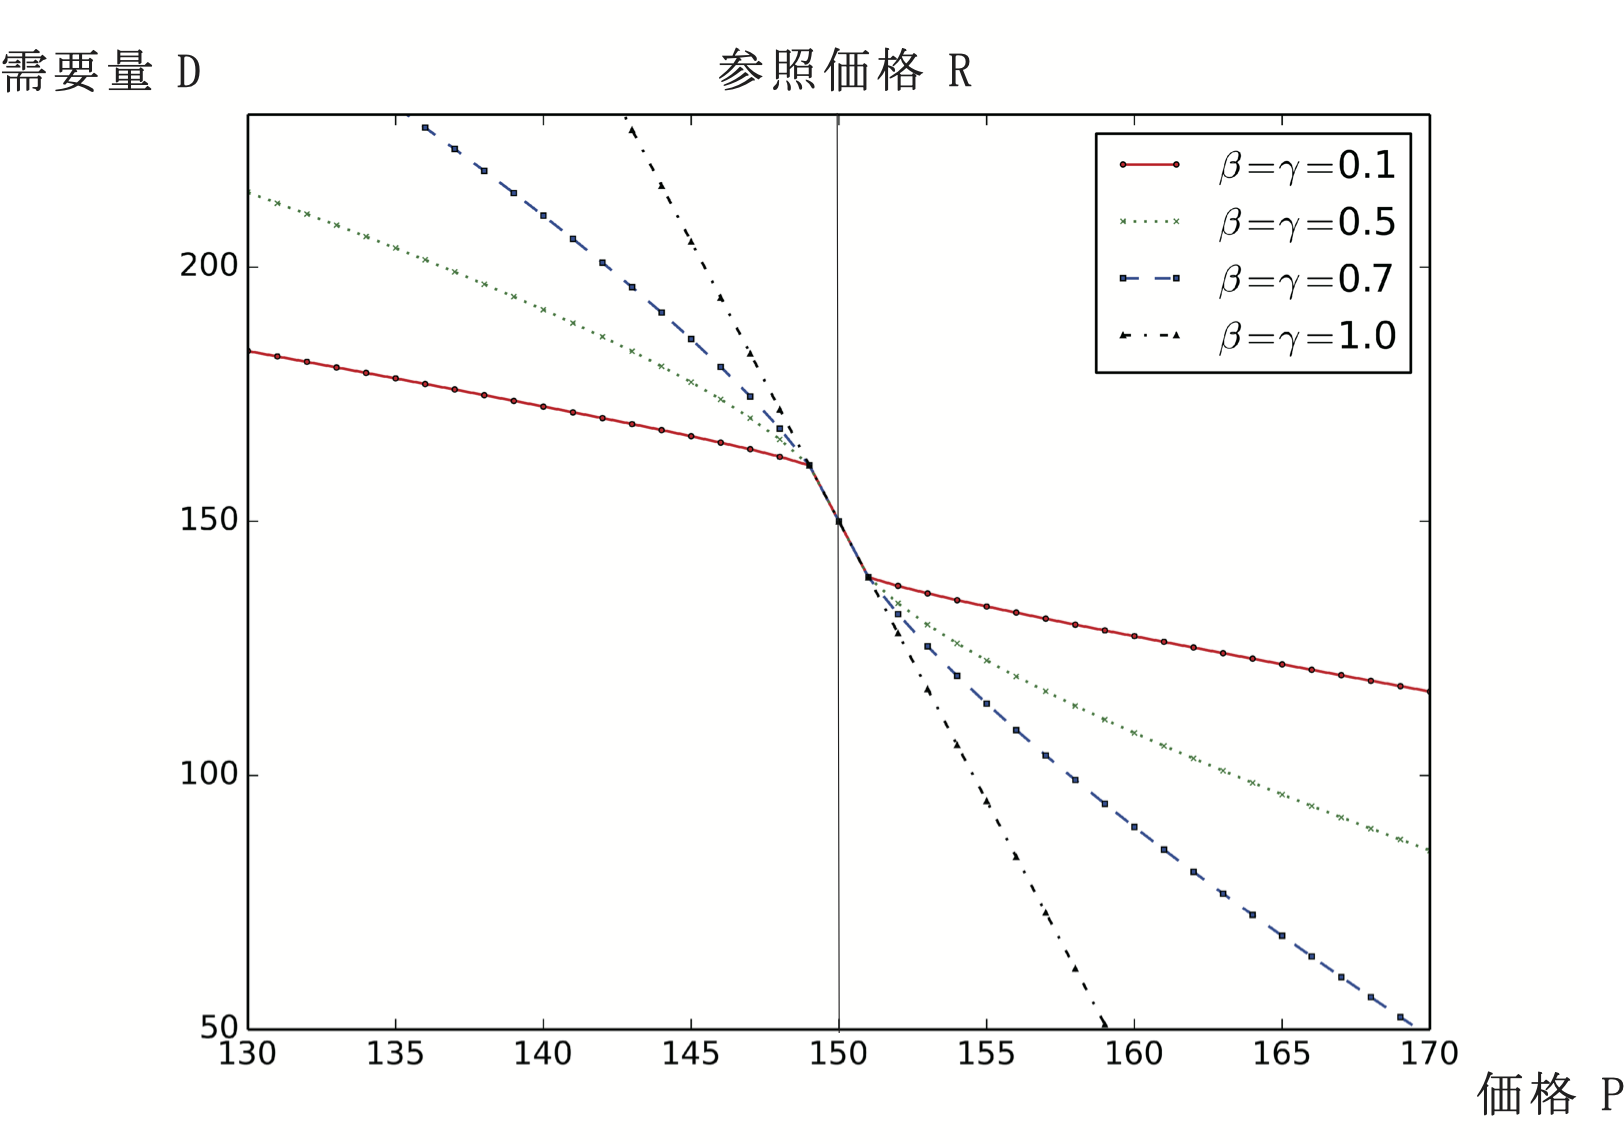

In [ ]:
#| echo: false
Image("../figure/prospect-demand.png", width=700)

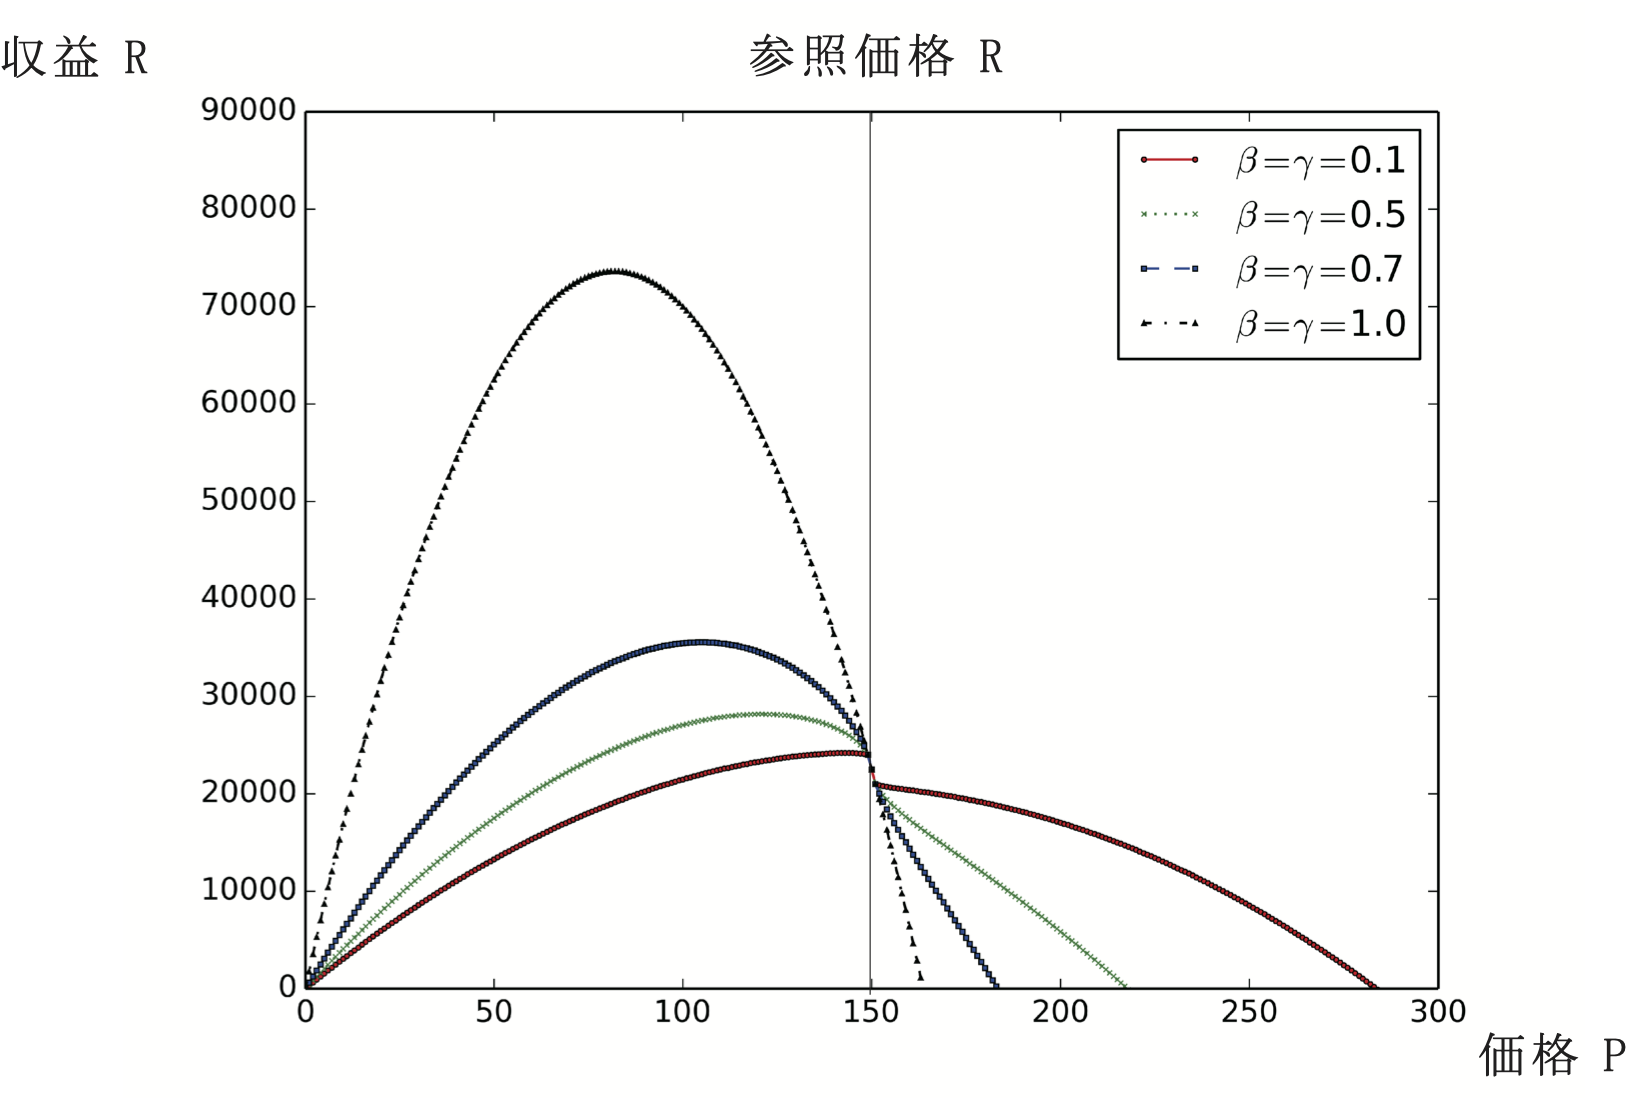

In [ ]:
#| echo: false
Image("../figure/prespect-revenue.png", width=700)

### 最適化による実験結果

上の仮定の下で，実験を行う．実験の詳細については，拙著「サプライチェーンリスク管理と人道支援ロジスティクス」（近代科学社）を参照されたい．

参照価格のパラメータ $\alpha=0$（上図）， $\alpha=0.5$（下図）， 計画期間 $T=200$，$\zeta=8$，$\eta=12$ （ロス回避）とし，
リスク回避のパラメータ $\beta,\gamma$ を変えたときの最適価格の変化は， 以下のようになる．

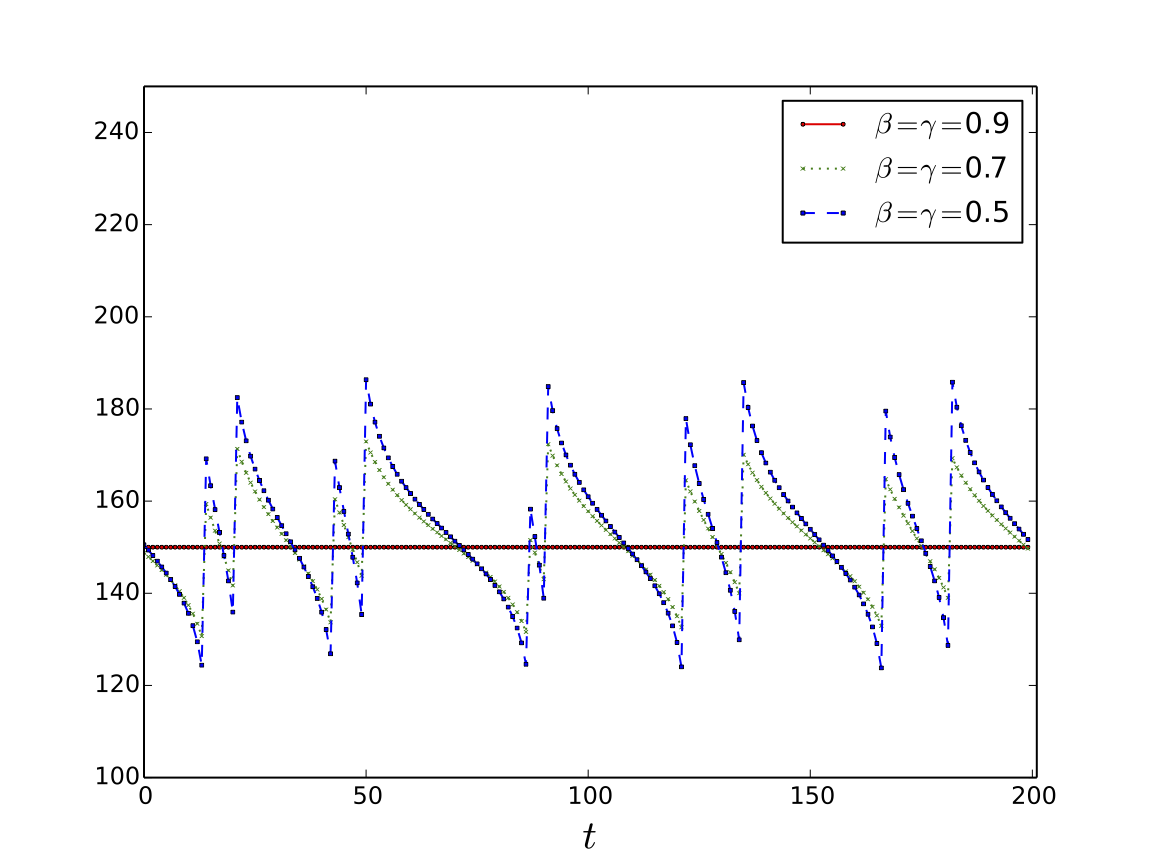

In [ ]:
#| echo: false
Image("../figure/prospect.png", width=700)

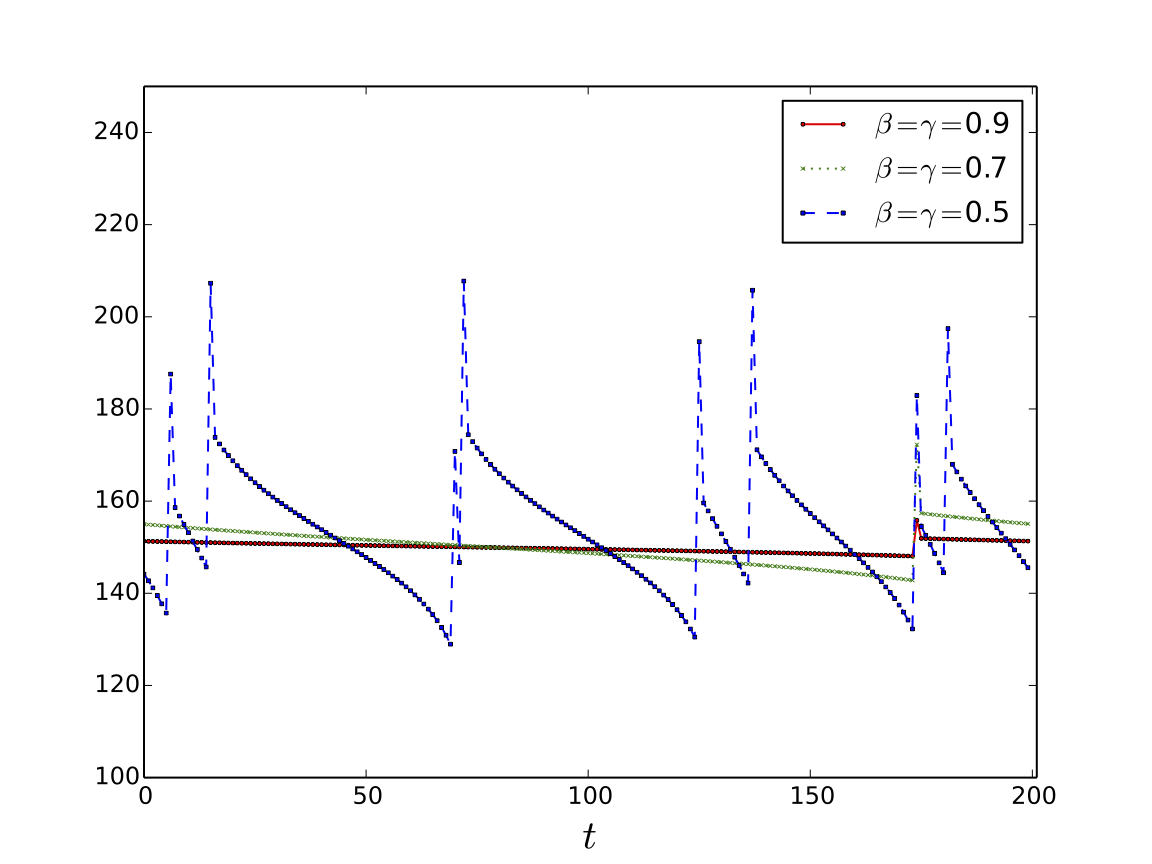

In [ ]:
#| echo: false
Image("../figure/prospect2.png", width=700)

この結果から以下の知見が得られる．

- 従来の研究では，固定価格方策が最適であると言われていたが，
価格を一時的に上昇させ，徐々に下げていく方策の方がより高い収益を上げる場合がある．
これは価格を急激に高く設定することによって参照価格を上げ，その後価格を下げた後に徐々に価格を下げていくことによって
線形の場合より多くの需要を獲得することを意味する．ロスの領域（価格が参照価格より高い領域）
における需要関数の凸性から，価格は徐々に上げるのではなく
一度に急激に上げた方が需要の減少は少ない．また，利益の領域（価格が参照価格より低い領域）における需要関数の凹性から，
価格は徐々に下げた方が需要の上昇が大きくなる．これをプロスペクト効果と名付ける．

-  $\beta,\gamma$ が小さい（凸性，凹性が大きい）ほど価格変更の周期が小さくなり，振幅が大きくなる．
-  $\alpha$ が小さいと参照価格の追従速度が速いので，価格変更の周期が小さくなる．
-  $\beta,\gamma$ が $1$ に近づくと固定価格方策が最適になる．これは従来の解析的モデルの結果と一致する．
